In [1]:
import sys
import os
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k
import tensorflow as tf

Using TensorFlow backend.
C:\Users\AVANISH SINGHAL\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\AVANISH SINGHAL\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\AVANISH SINGHAL\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [2]:
image_size = (299, 299)
batch_size = 32
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        shear_range=0.5,
        zoom_range=0.5,
        horizontal_flip=True,
        vertical_flip = True,
        validation_split=0.2,)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2,)

train_ds = train_datagen.flow_from_directory(
    "./breast-histopathology-images/8867/",
    subset="training",
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    class_mode = 'binary'
)
val_ds = test_datagen.flow_from_directory(
    "./breast-histopathology-images/8950/",
    subset="validation",
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    class_mode = 'binary'

)

Found 1138 images belonging to 2 classes.
Found 122 images belonging to 2 classes.


In [3]:
from keras.layers import Dense
from keras.regularizers import l2

base_model = Xception(input_shape=(299, 299, 3), weights='imagenet', include_top=False)

# Top Model Block
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = Dense(256,activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# add your top layer block to your base model
model = Model(base_model.input, predictions)
print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [4]:
for layer in base_model.layers:
        layer.trainable = False
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [5]:
model.compile(optimizer=Adam(1e-3),
              loss='sparse_categorical_crossentropy',  # categorical_crossentropy if multi-class classifier
              metrics=['accuracy'])



In [6]:
callbacks_list = [
    ModelCheckpoint('top_model_weights.h5', monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=5, verbose=0)
]

In [7]:
# Train Simple CNN
hist = model.fit_generator(
                   train_ds,
                   steps_per_epoch=1138/batch_size,
                   epochs=10,
                   validation_data=val_ds,
                   validation_steps=122/batch_size,
                   callbacks=callbacks_list)

# verbose
print("\nStarting to Fine Tune Model\n")

# add the best weights from the train top model
# at this point we have the pre-train weights of the base model and the trained weight of the new/added top model
# we re-load model weights to ensure the best epoch is selected and not the last one.
# model.load_weights('top_model_weights.h5')


Epoch 1/10
36/35 [==============================] - 715s 20s/step - loss: 4.9270 - accuracy: 0.7162 - val_loss: 4.0998 - val_accuracy: 0.6885
Epoch 2/10


C:\Users\AVANISH SINGHAL\AppData\Roaming\Python\Python37\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
C:\Users\AVANISH SINGHAL\AppData\Roaming\Python\Python37\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


36/35 [==============================] - 709s 20s/step - loss: 3.8816 - accuracy: 0.7540 - val_loss: 3.5225 - val_accuracy: 0.6885
Epoch 3/10
36/35 [==============================] - 712s 20s/step - loss: 3.2357 - accuracy: 0.7487 - val_loss: 2.9117 - val_accuracy: 0.6885
Epoch 4/10
36/35 [==============================] - 703s 20s/step - loss: 2.6700 - accuracy: 0.7671 - val_loss: 2.4518 - val_accuracy: 0.6885
Epoch 5/10
36/35 [==============================] - 684s 19s/step - loss: 2.2430 - accuracy: 0.7724 - val_loss: 2.1110 - val_accuracy: 0.6885
Epoch 6/10
36/35 [==============================] - 687s 19s/step - loss: 1.9570 - accuracy: 0.7715 - val_loss: 2.1984 - val_accuracy: 0.6885
Epoch 7/10
36/35 [==============================] - 684s 19s/step - loss: 1.7108 - accuracy: 0.7557 - val_loss: 1.8141 - val_accuracy: 0.6885
Epoch 8/10
36/35 [==============================] - 684s 19s/step - loss: 1.4468 - accuracy: 0.7953 - val_loss: 1.5769 - val_accuracy: 0.6885
Epoch 9/10
36/35 

In [8]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

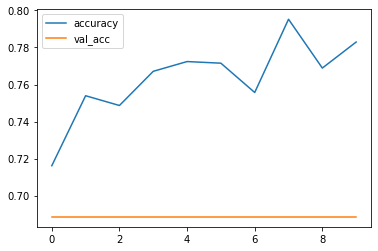

In [9]:
plt.plot(acc,label='accuracy')
plt.plot(val_acc,label='val_acc')
plt.legend()
plt.show()

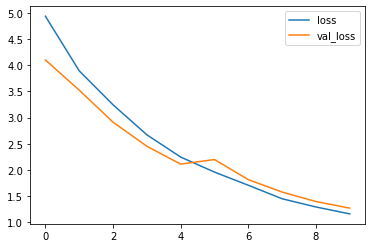

In [10]:
plt.plot(loss,label='loss')
plt.plot(val_loss,label= 'val_loss')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import classification_report, confusion_matrix


Y_pred = model.predict_generator(val_ds, 122 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_ds.classes, y_pred))
print('Classification Report')
target_names = ['noncancer', 'cancer']
print(classification_report(val_ds.classes, y_pred, target_names=target_names))


Confusion Matrix
[[ 0 38]
 [ 0 84]]
Classification Report
              precision    recall  f1-score   support

   noncancer       0.00      0.00      0.00        38
      cancer       0.69      1.00      0.82        84

   micro avg       0.69      0.69      0.69       122
   macro avg       0.34      0.50      0.41       122
weighted avg       0.47      0.69      0.56       122

